<a href="https://colab.research.google.com/github/drSever/drSever_data_science/blob/main/Learning_projects_dl/project_12/Denoising_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Оригинальный раздел ноутбука

In [1]:
%%capture
!pip install albumentations -U
!pip install opencv-python-headless==4.1.2.30

In [2]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset

from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from math import log10
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
device = torch.device('cuda')

In [4]:
class DnCNN(nn.Module):
  def __init__(self, n_layers=18):
    super(DnCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False)
    self.relu1 = nn.ReLU(inplace=True)

    hidden_layers = []
    for _ in range(n_layers):
      hidden_layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
      hidden_layers.append(nn.BatchNorm2d(64))
      hidden_layers.append(nn.ReLU(inplace=True))
    self.hidden = nn.Sequential(*hidden_layers)
    self.out = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1, bias=False)

  def forward(self, x):
    out = self.relu1(self.conv1(x))
    out = self.hidden(out)
    out = self.out(out)
    return out

In [5]:
model = DnCNN(n_layers=17).to(device)
model.eval()
output = model(torch.ones(1, 3, 100, 100).to(device))

In [6]:
output.shape

torch.Size([1, 3, 100, 100])

In [7]:
class UniversalDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, gaussian_noise_level=(0, 55),
                 transform=None):
      self.data = dataset
      self.transforms = transform
      self.gaussian_noise_level = gaussian_noise_level

    def __len__(self):
        return self.data.__len__()

    def __getitem__(self, idx):
      clean_image, label = self.data.__getitem__(idx)

      noisy_image = clean_image.copy()
      gaussian_noise = np.zeros((100, 100, 3), dtype=np.float32)

      sigma = random.randint(self.gaussian_noise_level[0], self.gaussian_noise_level[1])
      gaussian_noise += np.random.normal(0.0, sigma, (100, 100, 3)).astype(np.float32)

      image = np.array(clean_image)
      image = cv2.resize(image, (100, 100))
      noisy_image = cv2.resize(np.array(noisy_image), (100, 100)).astype(np.float32)

      if self.transforms:
        img = self.transforms(image=image)['image']

      noisy_image += gaussian_noise
      return img, torch.Tensor(image), torch.Tensor(gaussian_noise), torch.Tensor(noisy_image)

In [8]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [9]:
train_transforms = A.Compose(
[
      A.OneOf([
               A.GaussNoise(var_limit=(10, 100), p=1),
               A.ISONoise(intensity=(0.3, 0.9), p=1),
               A.MultiplicativeNoise(p=1)
               ]),
      ToTensorV2()
])
dataset = UniversalDataset(torchvision.datasets.STL10('.../train', download=True),
                           transform=train_transforms)

100%|██████████| 2640397119/2640397119 [06:29<00:00, 6774998.47it/s]


Extracting .../train/stl10_binary.tar.gz to .../train


In [10]:
img1, img2, _, _ = dataset.__getitem__(0)

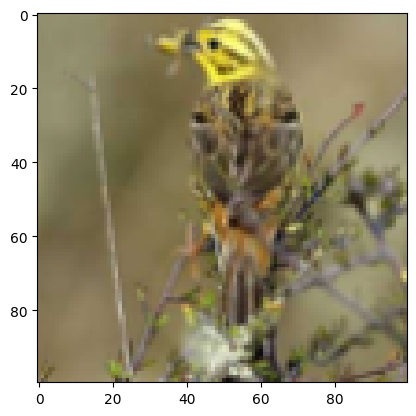

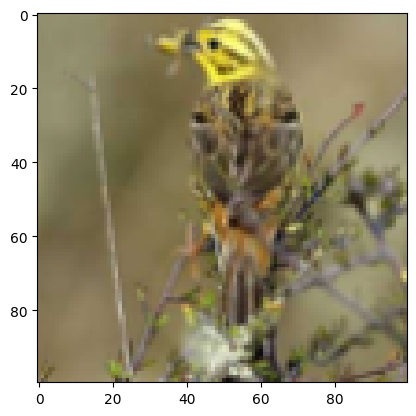

In [11]:
plt.imshow(img1.permute(1, 2, 0).numpy())
plt.show()

plt.imshow(img2.numpy().astype(np.uint8))
plt.show()

In [12]:
dataset = train_val_dataset(dataset)

train_dataset = dataset['val']

batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)

criterion = nn.MSELoss()

lr = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=lr)
model = model.to(device)

In [ ]:
epochs = 5
for epoch in range(1, epochs+1):
  epoch_loss = 0
  model.train()
  for iteration, data in enumerate(train_dataloader):

      input, target, _, _ = data
      input, target = input.to(device)/255, target.to(device)/255

      output = model(input)

      loss = criterion(output, target.permute(0, 3, 1, 2))
      epoch_loss += loss.item()

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()


      print("===> Epoch[{}]({}/{}): "
            "Loss: {:.4f}".format(epoch, iteration,
                                  len(train_dataloader),
                                  loss.item()))
  print("===> Epoch {} Complete: "
        "Avg. Loss: {:.4f}".format(epoch,
                                    epoch_loss / len(train_dataloader)))


  avg_psnr = 0
  model.eval()
  with torch.no_grad():
      for data in train_dataloader:
        input, target, _, _ = data
        input, target = input.to(device)/255, target.to(device)/255
        output = model(input)
        mse = criterion(output, target.permute(0, 3, 1, 2))
        psnr = 10 * log10(1 / mse.item())
        avg_psnr += psnr
  print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(train_dataloader)))

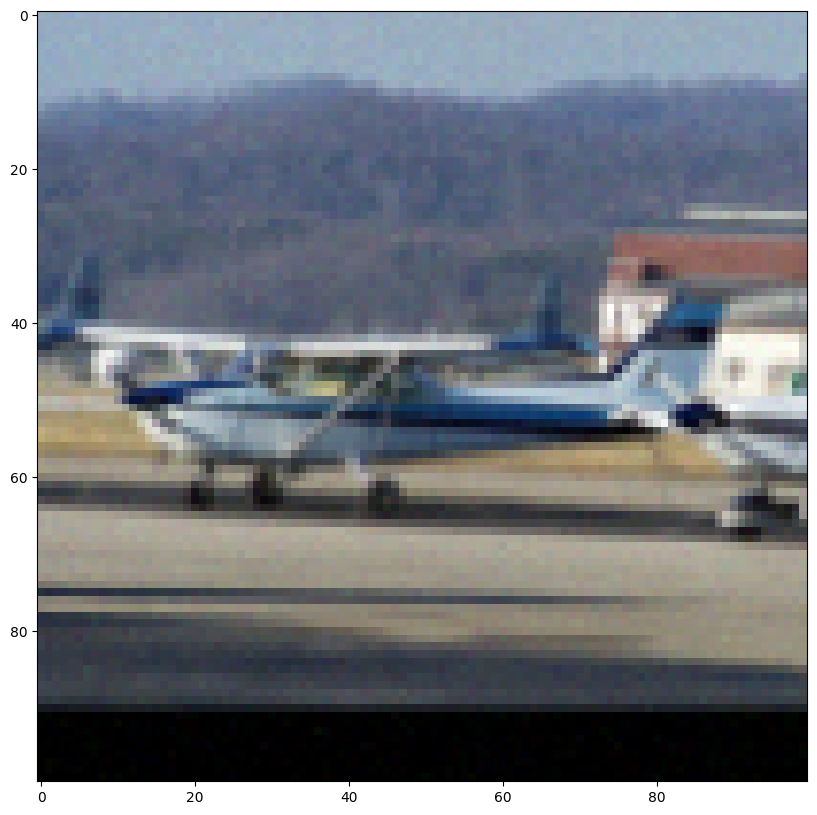

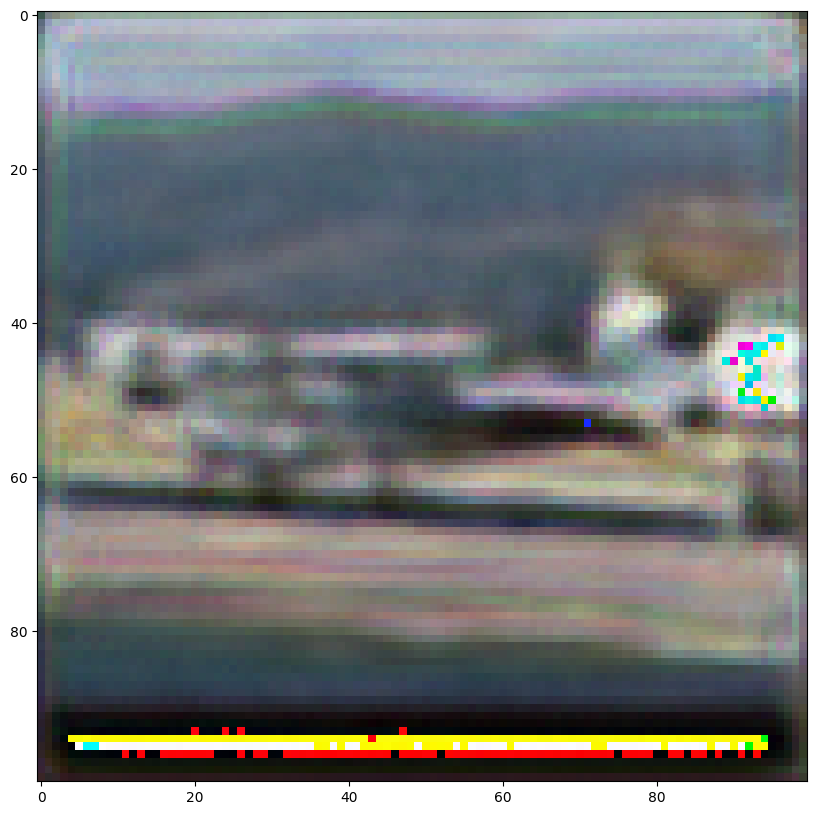

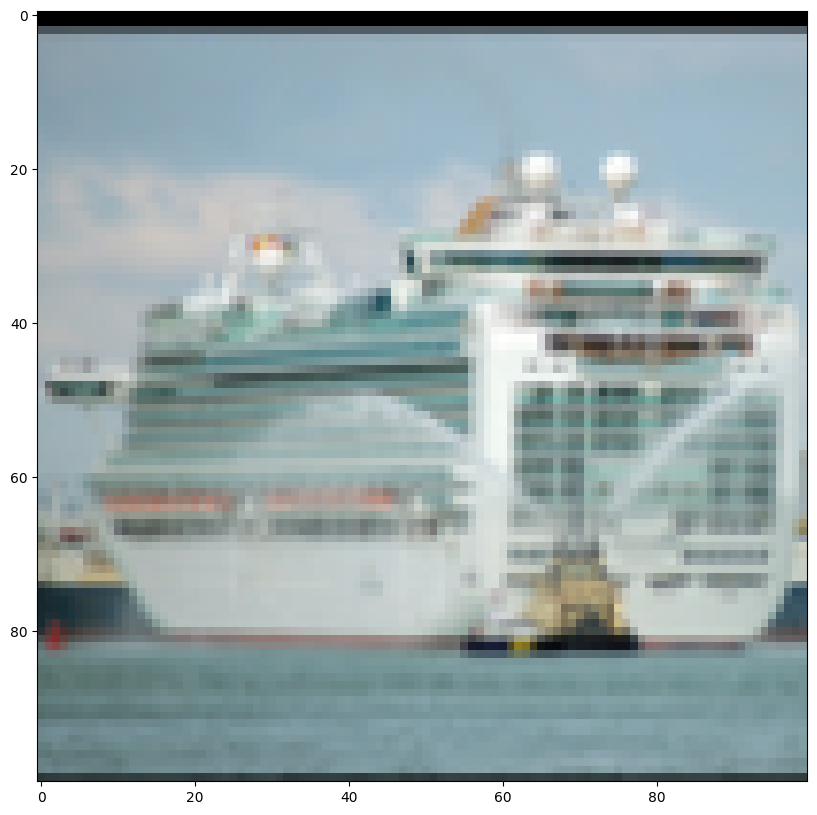

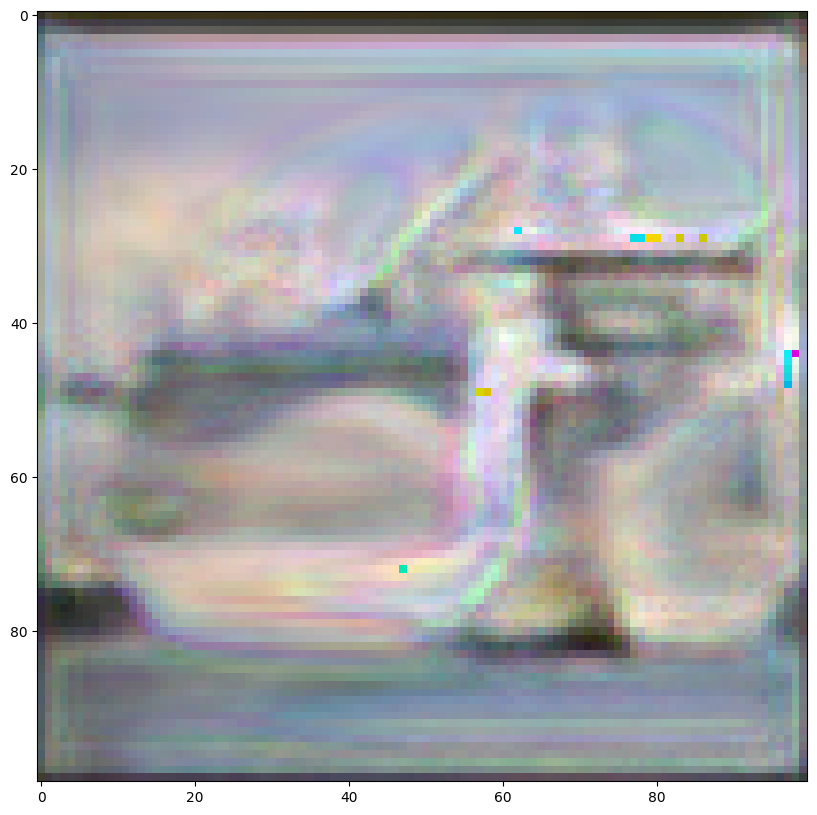

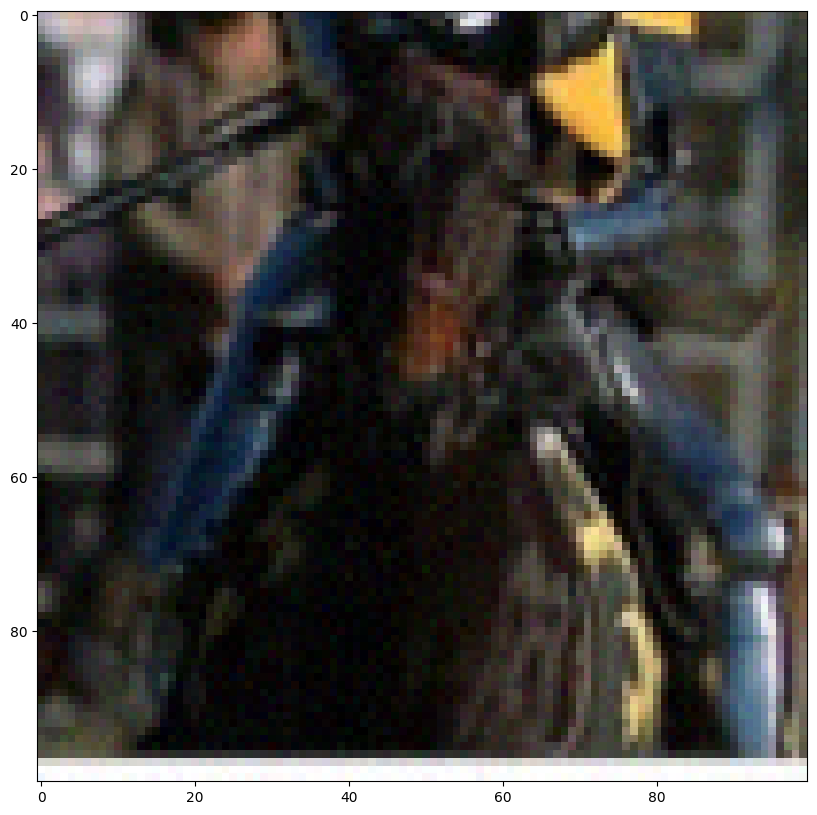

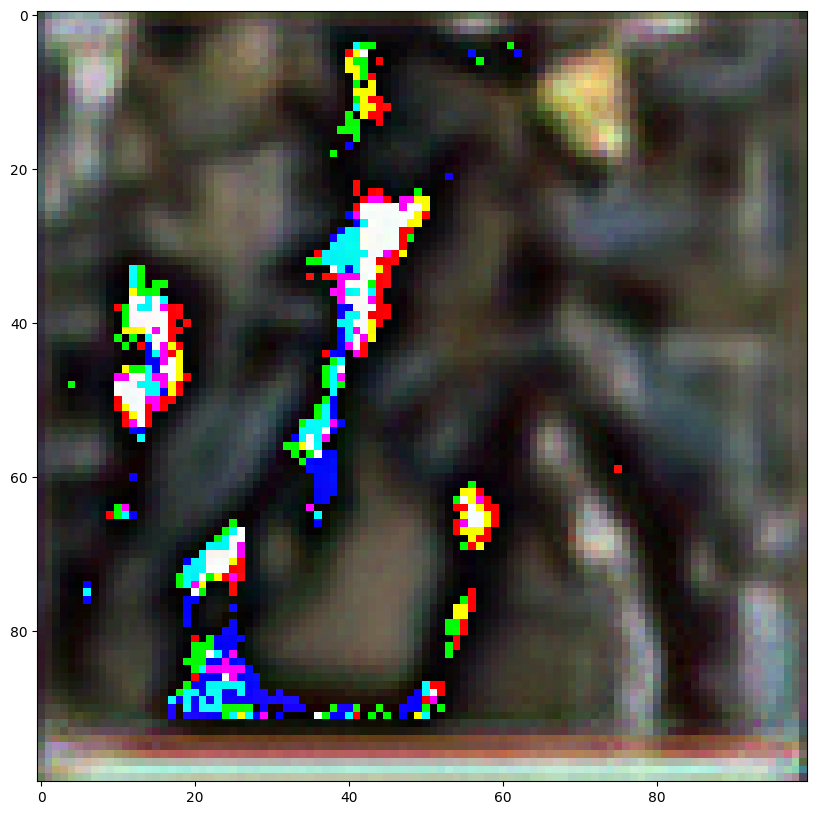

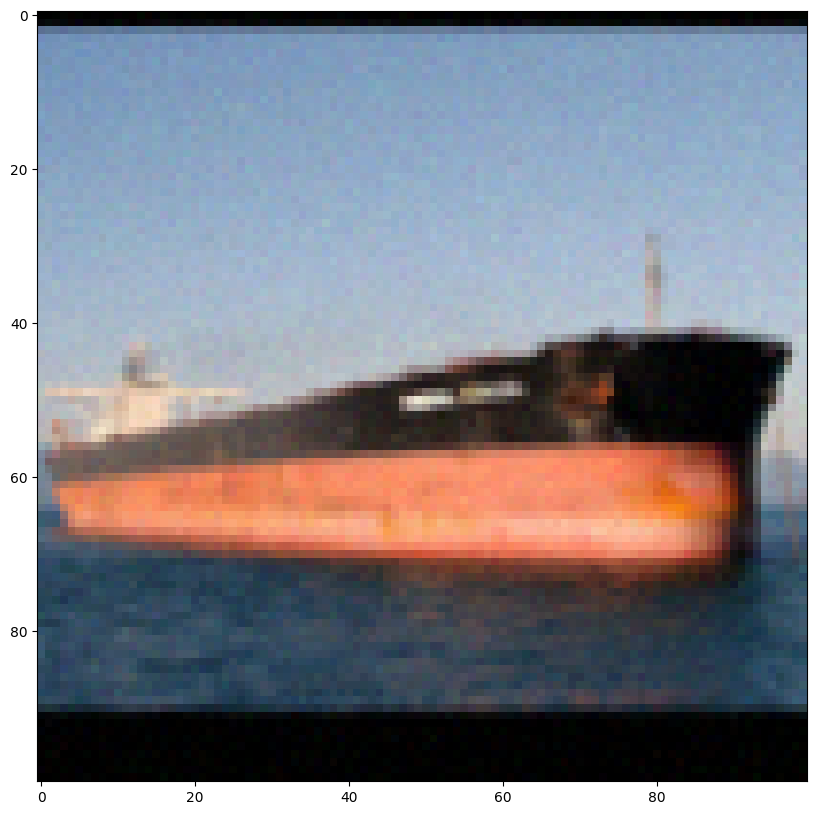

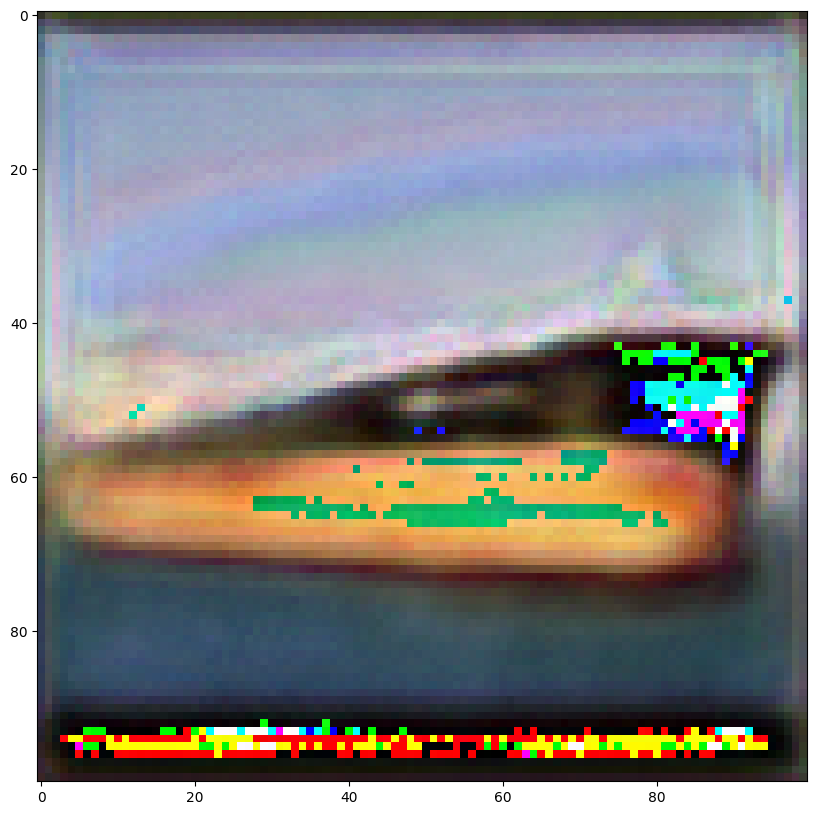

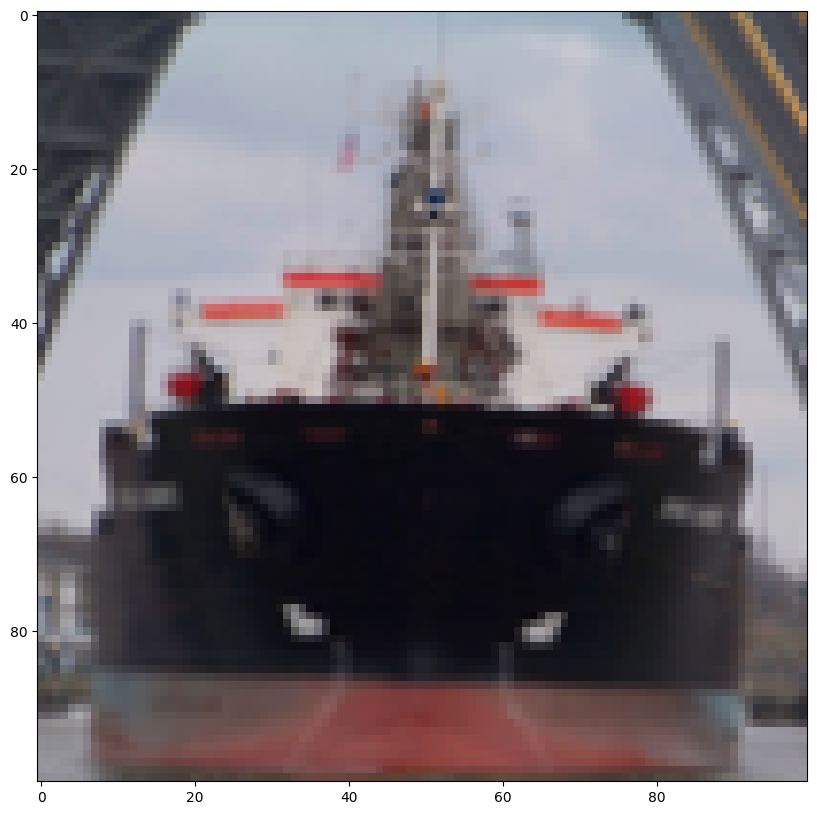

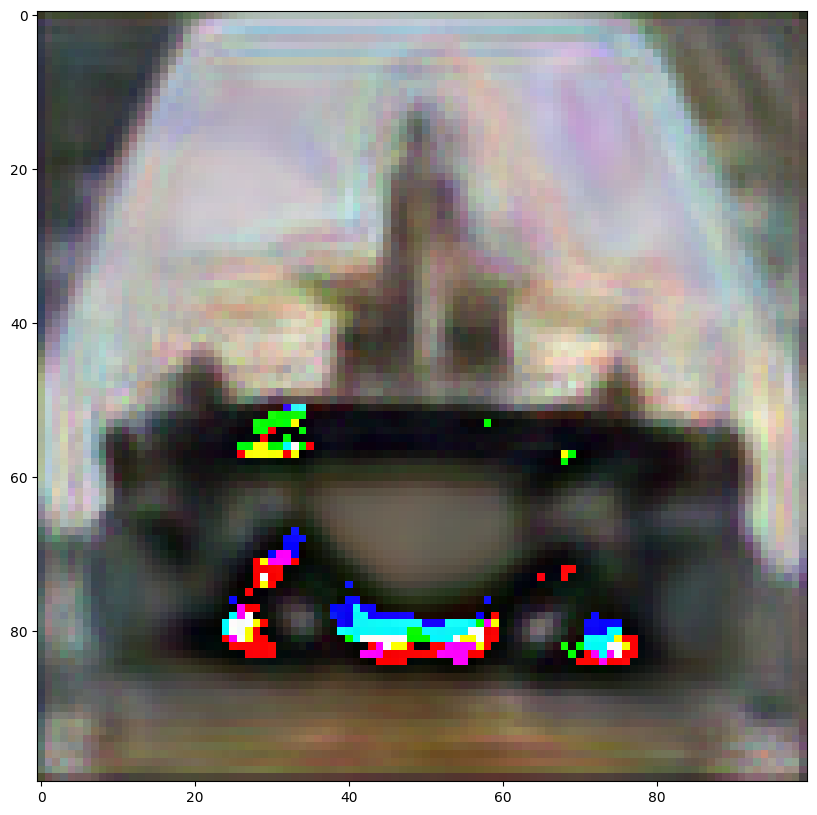

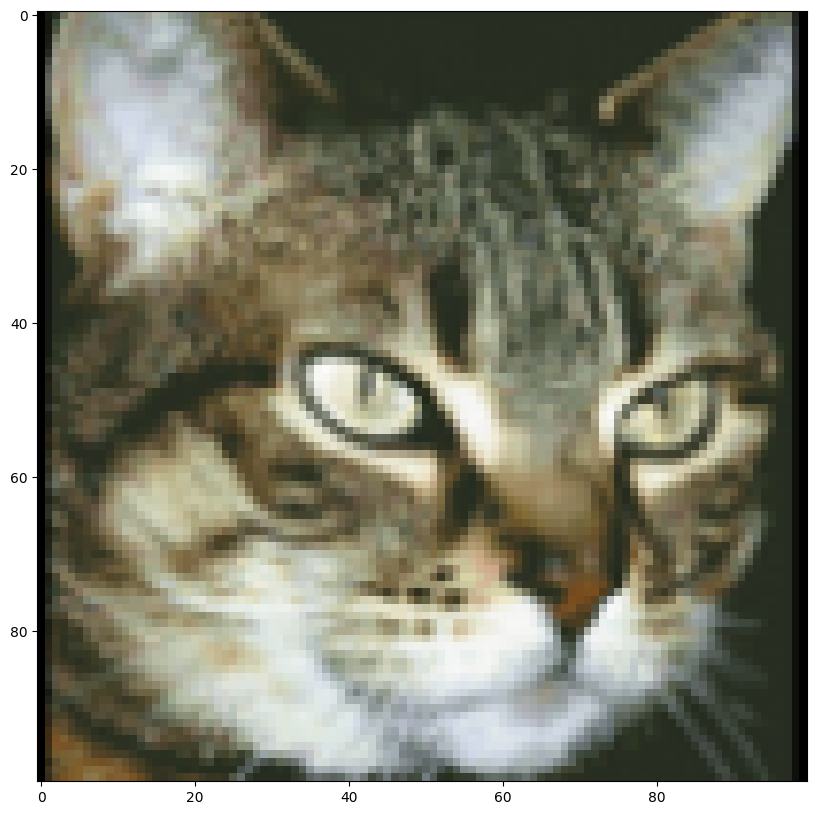

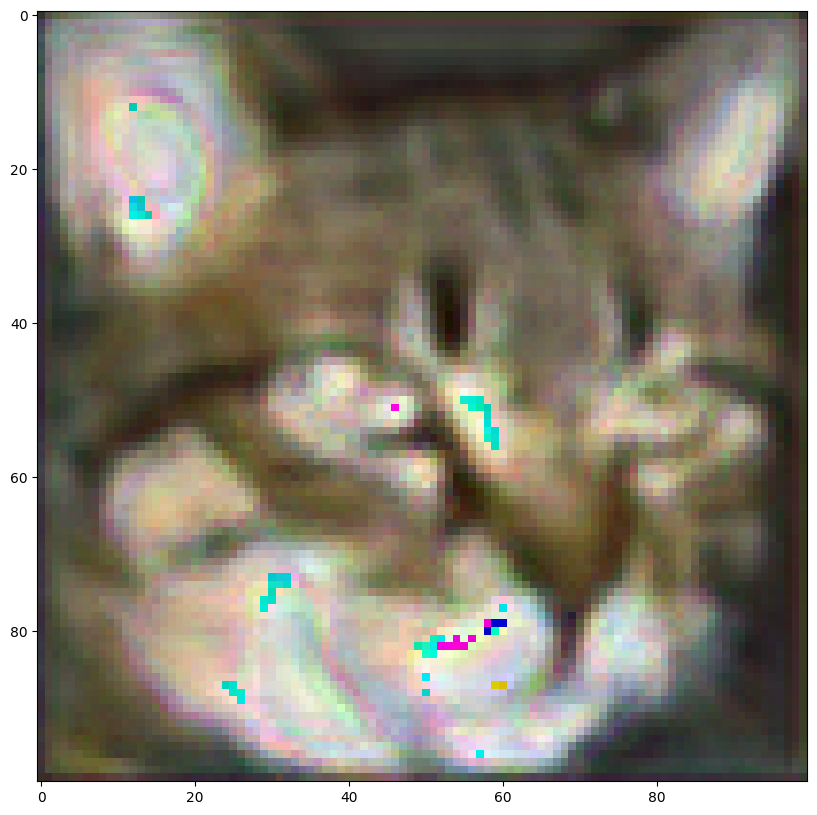

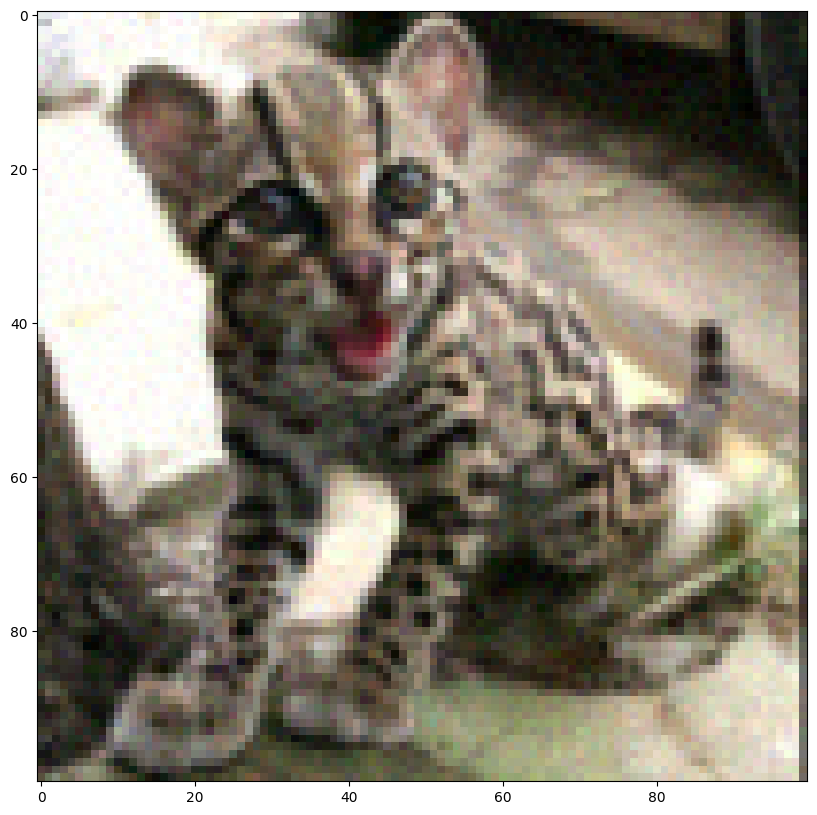

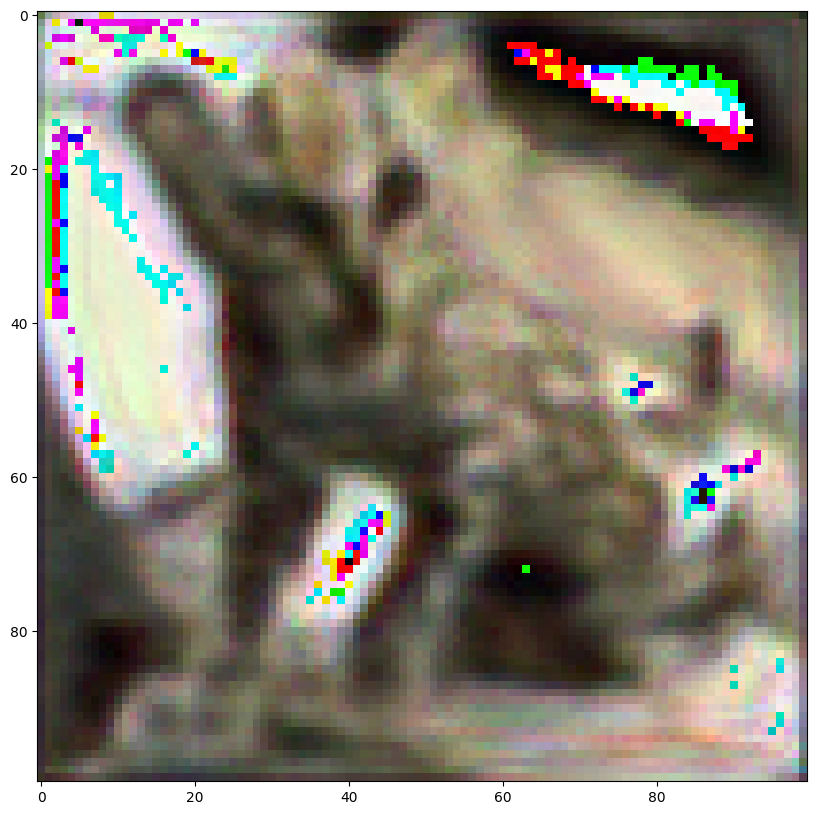

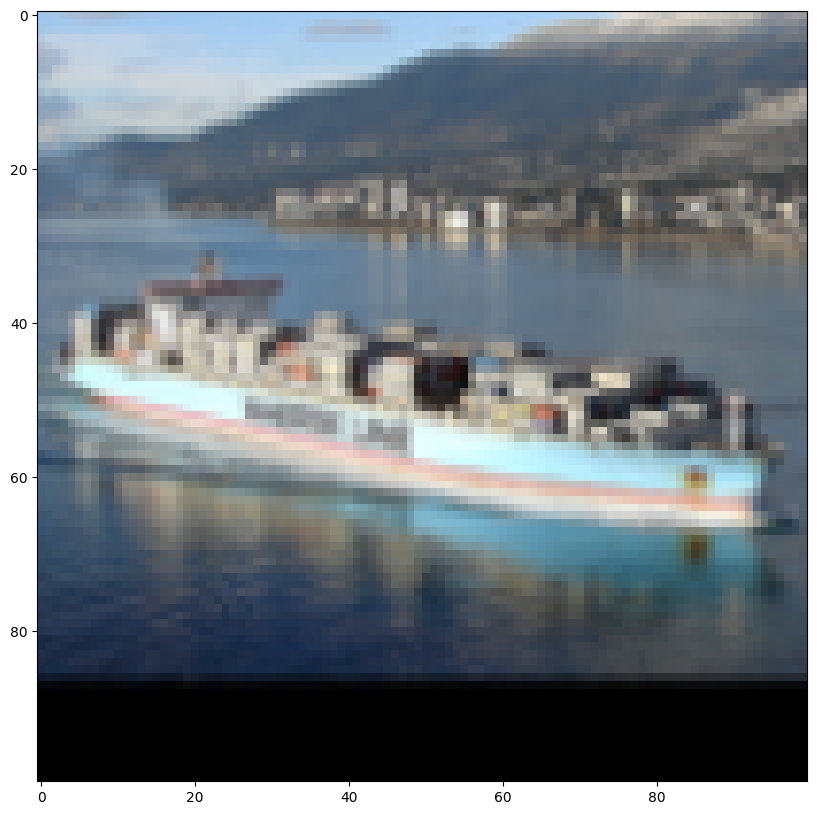

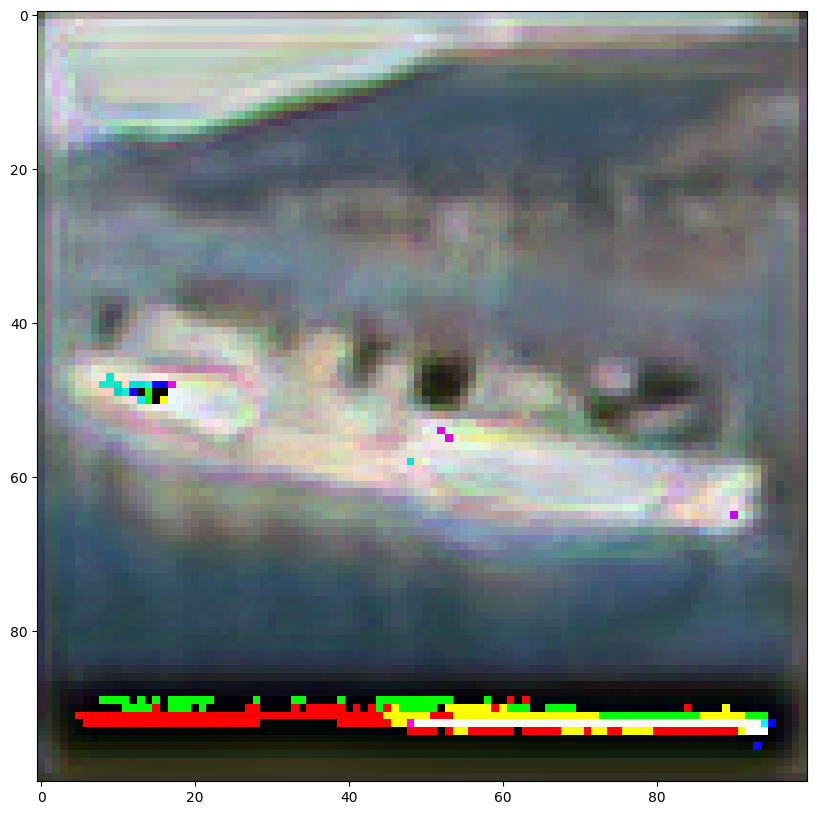

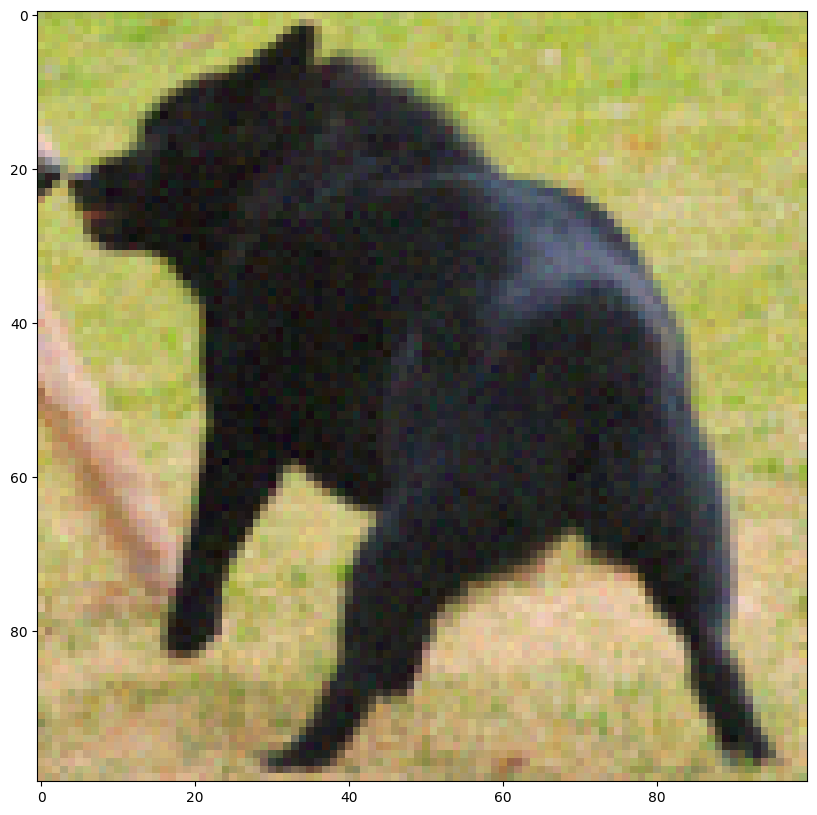

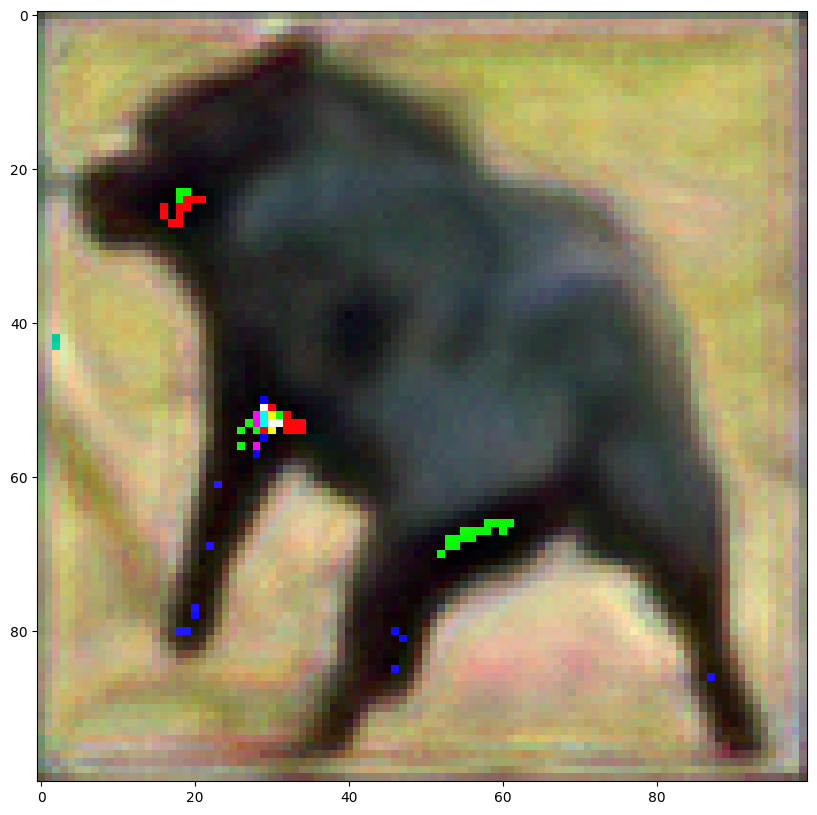

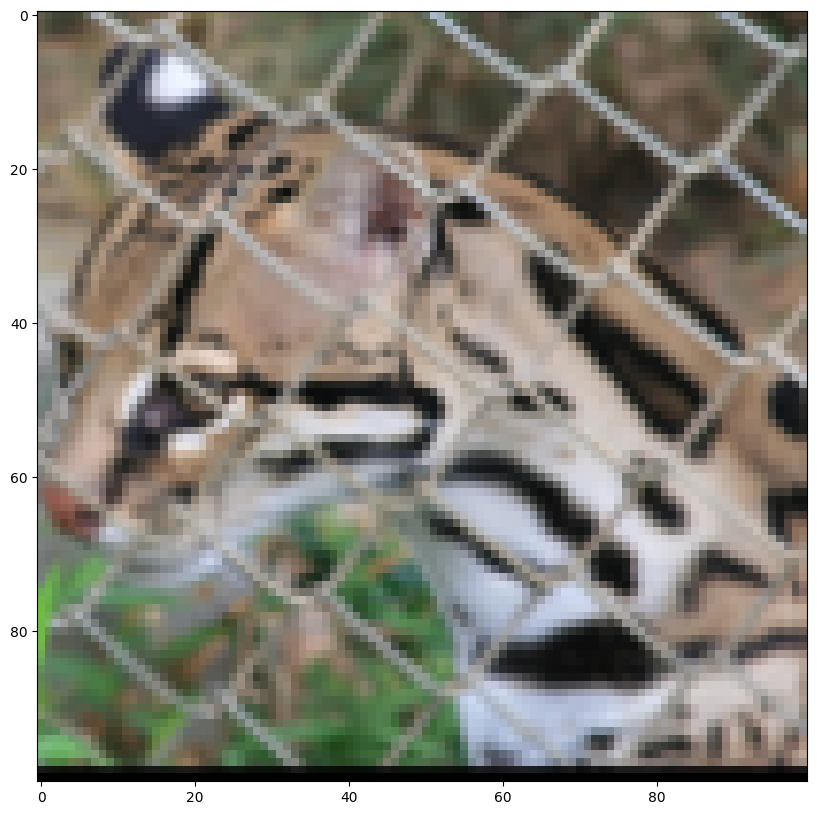

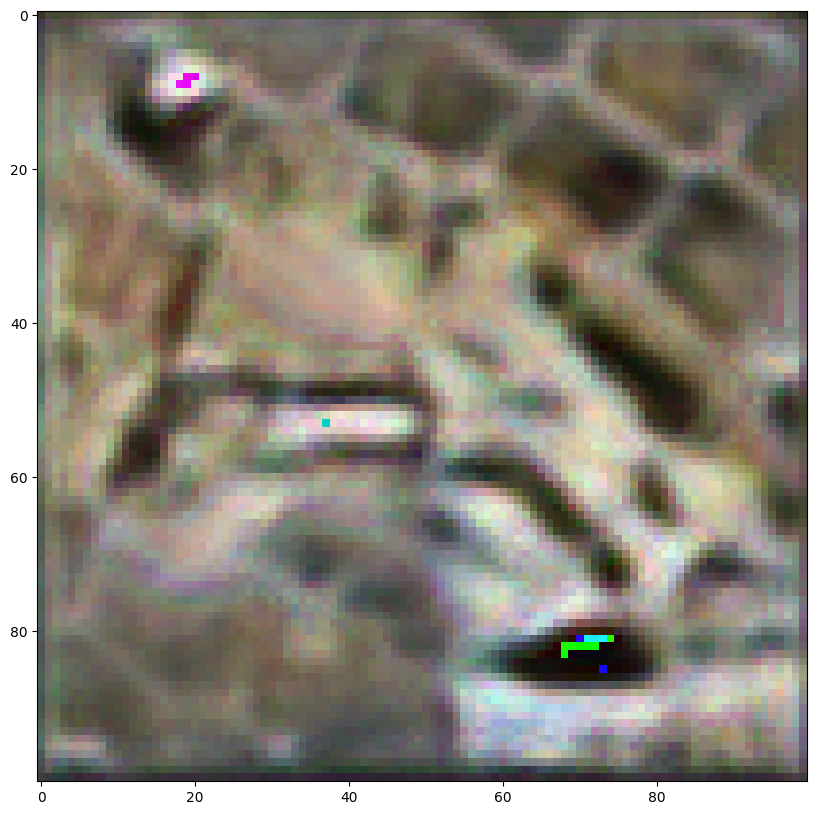

In [15]:
k = 0
with torch.no_grad():
    for data in train_dataloader:
      input, target, _, _ = data
      input, target = input.to(device)/255, target.to(device)/255
      output = model(input)
      output = (output[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      input = (input[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

      plt.figure(figsize=(10, 10))
      plt.imshow(input)
      plt.show()

      plt.figure(figsize=(10, 10))
      plt.imshow(output)
      plt.show()
      k+=1
      if k == 10:
        break

---
---

# Домашнее задание

Ваша задача — заполнить слои в наброске автоэнкодера, запустить обучение и получить результат метрики PSNR не менее 23.

# Решение

- За основу взят автоэнкодер из данной работы на [Kaggle](https://www.kaggle.com/code/alaaeddinebenzekri/image-denoising-using-autoencoder-pytorch/notebook). Правда, в своей работе автор обучал его на другом датасете, а именно на [FFHQ Faces Data Set](https://www.kaggle.com/datasets/greatgamedota/ffhq-face-data-set).
- Исправлена опечатка автора представленного оригинального ноутбука, где он проводит обучение на валидационной выборке, а не на тренировочной.
- Добавлены комментарии там, где оригинальный код автора изменялся или дополнялся.

## Импорт необходимых библиотек

In [4]:
from torchsummary import summary

# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

## Подготовка данных

Скопипастим класс датасета, предложенный автором, однако изменим размер изображений до 103х103, почему - объясню ниже.

In [5]:
class UniversalDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, gaussian_noise_level=(0, 55),
                 transform=None):
      self.data = dataset
      self.transforms = transform
      self.gaussian_noise_level = gaussian_noise_level

    def __len__(self):
        return self.data.__len__()

    def __getitem__(self, idx):
      clean_image, label = self.data.__getitem__(idx)

      noisy_image = clean_image.copy()
      gaussian_noise = np.zeros((103, 103, 3), dtype=np.float32)

      sigma = random.randint(self.gaussian_noise_level[0], self.gaussian_noise_level[1])
      gaussian_noise += np.random.normal(0.0, sigma, (103, 103, 3)).astype(np.float32)

      image = np.array(clean_image)
      image = cv2.resize(image, (103, 103))
      noisy_image = cv2.resize(np.array(noisy_image), (103, 103)).astype(np.float32)

      if self.transforms:
        img = self.transforms(image=image)['image']

      noisy_image += gaussian_noise
      return img, torch.Tensor(image), torch.Tensor(gaussian_noise), torch.Tensor(noisy_image)

Также скопипастим функцию разделения датасета

In [6]:
def train_val_dataset(dataset, val_split=0.25):
    """
    Функция разделяет исходный датасет на тренировочную и валидационную части.
    Args:
      dataset: исходный датасет
      val_split: доля валидационной выборки
    Returns:
      datasets: словарь с ключами 'train' и 'val' значениями которых являются
                соответствующие выборки
    """
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

Различные трансформации Albumentations осложняют обучение, кстати автор автоэнкодера также их не использует.

In [7]:
train_transforms = A.Compose(
[
      #A.OneOf([
      #         A.GaussNoise(var_limit=(10, 100), p=1),
      #         A.ISONoise(intensity=(0.3, 0.9), p=1),
      #         A.MultiplicativeNoise(p=1),
      #         A.ChannelDropout(channel_drop_range=(1, 1), fill_value=0, always_apply=None, p=0.5)
      #         ]),
      ToTensorV2()
])
dataset = UniversalDataset(torchvision.datasets.STL10('.../train', download=True),
                           transform=train_transforms)

100%|██████████| 2640397119/2640397119 [04:30<00:00, 9749663.63it/s]


Extracting .../train/stl10_binary.tar.gz to .../train


Выведем пример элемента датасета:

In [8]:
img1, img2, img3, img4 = dataset.__getitem__(0)

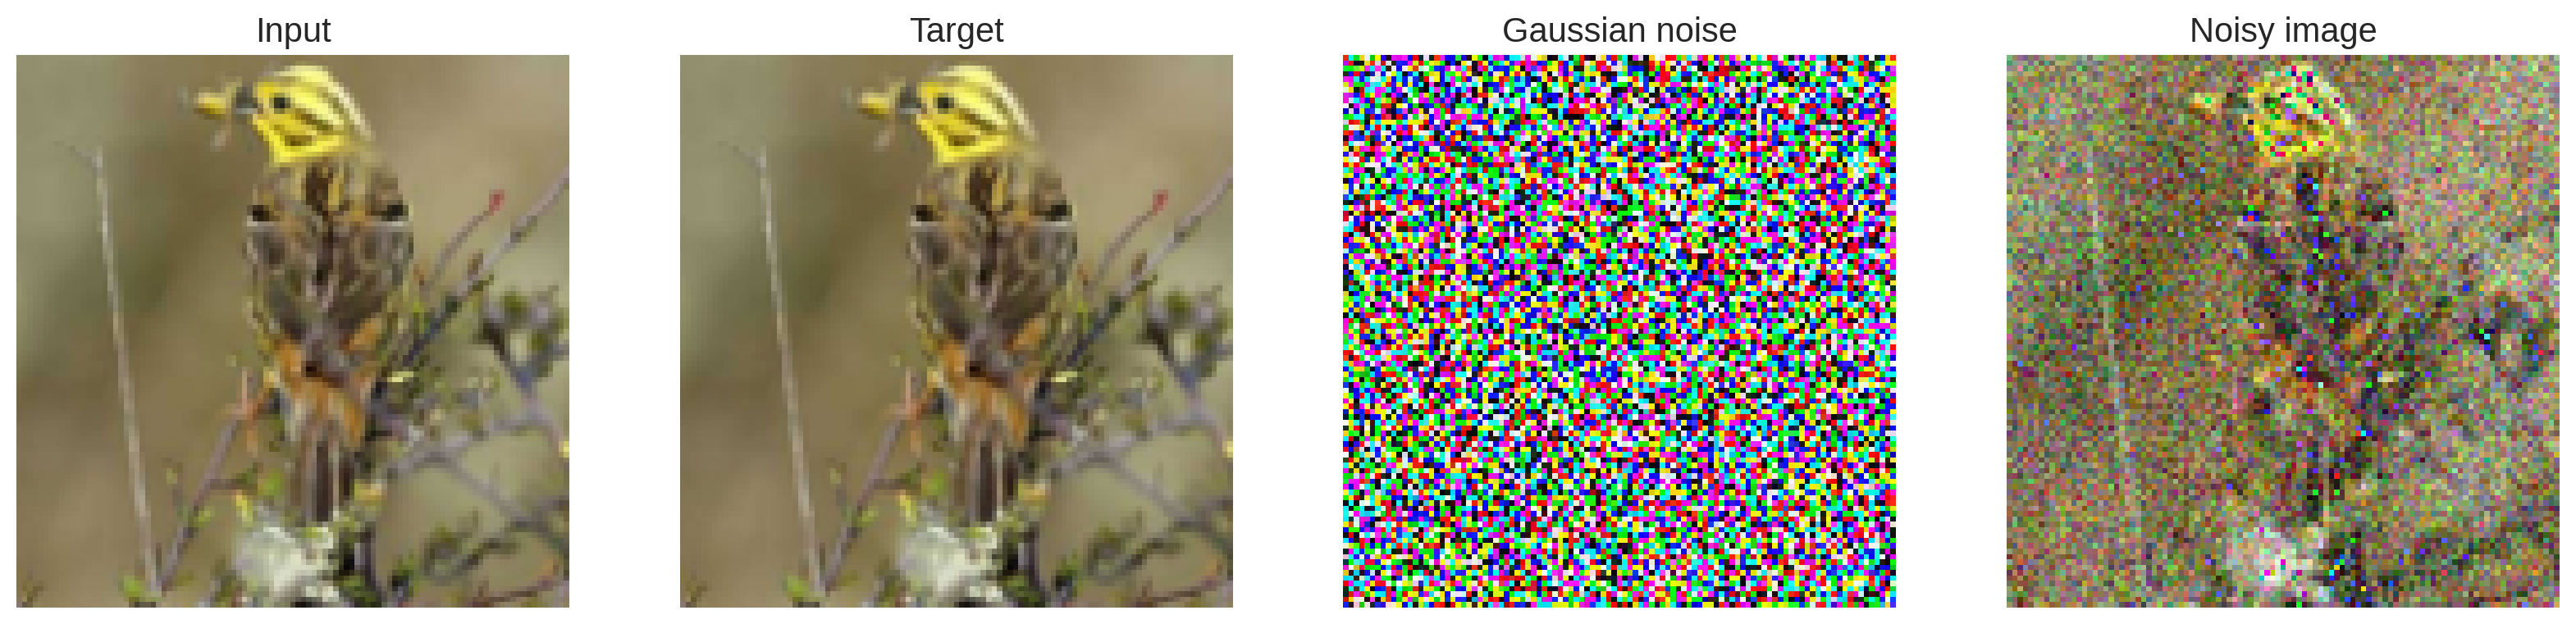

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(141), plt.imshow(img1.permute(1, 2, 0).numpy()), plt.axis('off'), plt.title('Input', size=15)
plt.subplot(142), plt.imshow(img2.numpy().astype(np.uint8)), plt.axis('off'), plt.title('Target', size=15)
plt.subplot(143), plt.imshow(img3.numpy().astype(np.uint8)), plt.axis('off'), plt.title('Gaussian noise', size=15)
plt.subplot(144), plt.imshow(img4.numpy().astype(np.uint8)), plt.axis('off'), plt.title('Noisy image', size=15)
plt.show()

Мы видим, что элемент датасета состоит из 4-х изображений (точнее из их тензоров):
- изображение, которое через трансформацию в тензор подается на вход модели
- таргет в виде тензора (по сути, исходное изображение)
- сгенерированный шум
- наложение шума на исходное изображение

## Модель автоэнкодера

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(32, 64, kernel_size = 3, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(64, 128, kernel_size = 3, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size = 3, stride = 1, padding = 1),
            nn.Sigmoid()
        )

    def forward(self, images):
        x = self.encoder(images)
        x = self.decoder(x)
        return x

In [11]:
model = AutoEncoder().to(device)
model.eval()

# прогоним тестовый тензор
output = model(torch.ones(1, 3, 103, 103).to(device))
output.shape

torch.Size([1, 3, 103, 103])

In [12]:
# проанализируем архитектуру и прогоним еще раз тестовый тензор
summary(model, (3, 103, 103))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 103, 103]             896
              ReLU-2         [-1, 32, 103, 103]               0
         MaxPool2d-3           [-1, 32, 51, 51]               0
            Conv2d-4           [-1, 64, 51, 51]          18,496
              ReLU-5           [-1, 64, 51, 51]               0
         MaxPool2d-6           [-1, 64, 25, 25]               0
            Conv2d-7          [-1, 128, 25, 25]          73,856
              ReLU-8          [-1, 128, 25, 25]               0
         MaxPool2d-9          [-1, 128, 12, 12]               0
  ConvTranspose2d-10          [-1, 128, 25, 25]         147,584
             ReLU-11          [-1, 128, 25, 25]               0
  ConvTranspose2d-12           [-1, 64, 51, 51]          73,792
             ReLU-13           [-1, 64, 51, 51]               0
  ConvTranspose2d-14         [-1, 32, 1

**Примечание.** Как можно заметить, в отличие от авторской задумки ресайзить изображения в размер 100х100, мы их ресайзим в размер 103х103. Дело в том, что при прогоне тестового тензора размером 100х100 на выходе автоэнкодера мы получаем размерность 103х103, а если мы подаем на вход 103х103, то размерность выходного тензора сохраняется 103х103. Это как-то связано, на сколько я понимаю, с особенностями вычислений и округлений на каких-то этапах, но я , к сожалению, не разобрался на каких, поэтому решил данную проблему таким образом.

## Обучение

Learning Rate подобран экспериментально, как оказалось такой же lr выставил и автор автоэнкодера.

In [13]:
dataset = train_val_dataset(dataset)

train_dataset = dataset['train']

batch_size = 1024 # для T4 в Google Colab

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)

criterion = nn.MSELoss()

lr = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=lr)
model = model.to(device)

In [ ]:
epochs = 1000
loss_list = []
psnr_list = []
for epoch in range(1, epochs+1):
  epoch_loss = 0
  model.train()
  for iteration, data in enumerate(train_dataloader):

      input, target, _, _ = data

      ### попытка подавать на вход зашумленное изображение - неэффективно
      #_, target, _, input = data
      #input = torch.permute(input, (0,3,1,2))

      input, target = input.to(device)/255, target.to(device)/255

      output = model(input)

      loss = criterion(output, target.permute(0, 3, 1, 2))
      epoch_loss += loss.item()

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      avg_loss = epoch_loss / len(train_dataloader) # рассчитываем loss

      print("===> Epoch[{}]({}/{}): "
            "Loss: {:.4f}".format(epoch, iteration,
                                  len(train_dataloader),
                                  loss.item()))
  print("===> Epoch {} Complete: "
        "Avg. Loss: {:.4f}".format(epoch,
                                    avg_loss))

  loss_list.append(avg_loss) # сохраняем loss


  avg_psnr = 0
  model.eval()
  with torch.no_grad():
      for data in train_dataloader:
        input, target, _, _ = data
        input, target = input.to(device)/255, target.to(device)/255
        output = model(input)
        mse = criterion(output, target.permute(0, 3, 1, 2))
        psnr = 10 * log10(1 / mse.item())
        avg_psnr += psnr

        total_avg_psnr = avg_psnr / len(train_dataloader) # рассчитываем psnr

  print("===> Avg. PSNR: {:.4f} dB".format(total_avg_psnr))

  psnr_list.append(total_avg_psnr) # сохраняем psnr

  if total_avg_psnr >= 23: # критерий остановки обучения
    break

**Примечание:** я , как новичок, решил поэкспериментировать и попробовал подавать в модель не исходное, а уже зашумленное изображение - результат неудовлетворительный.

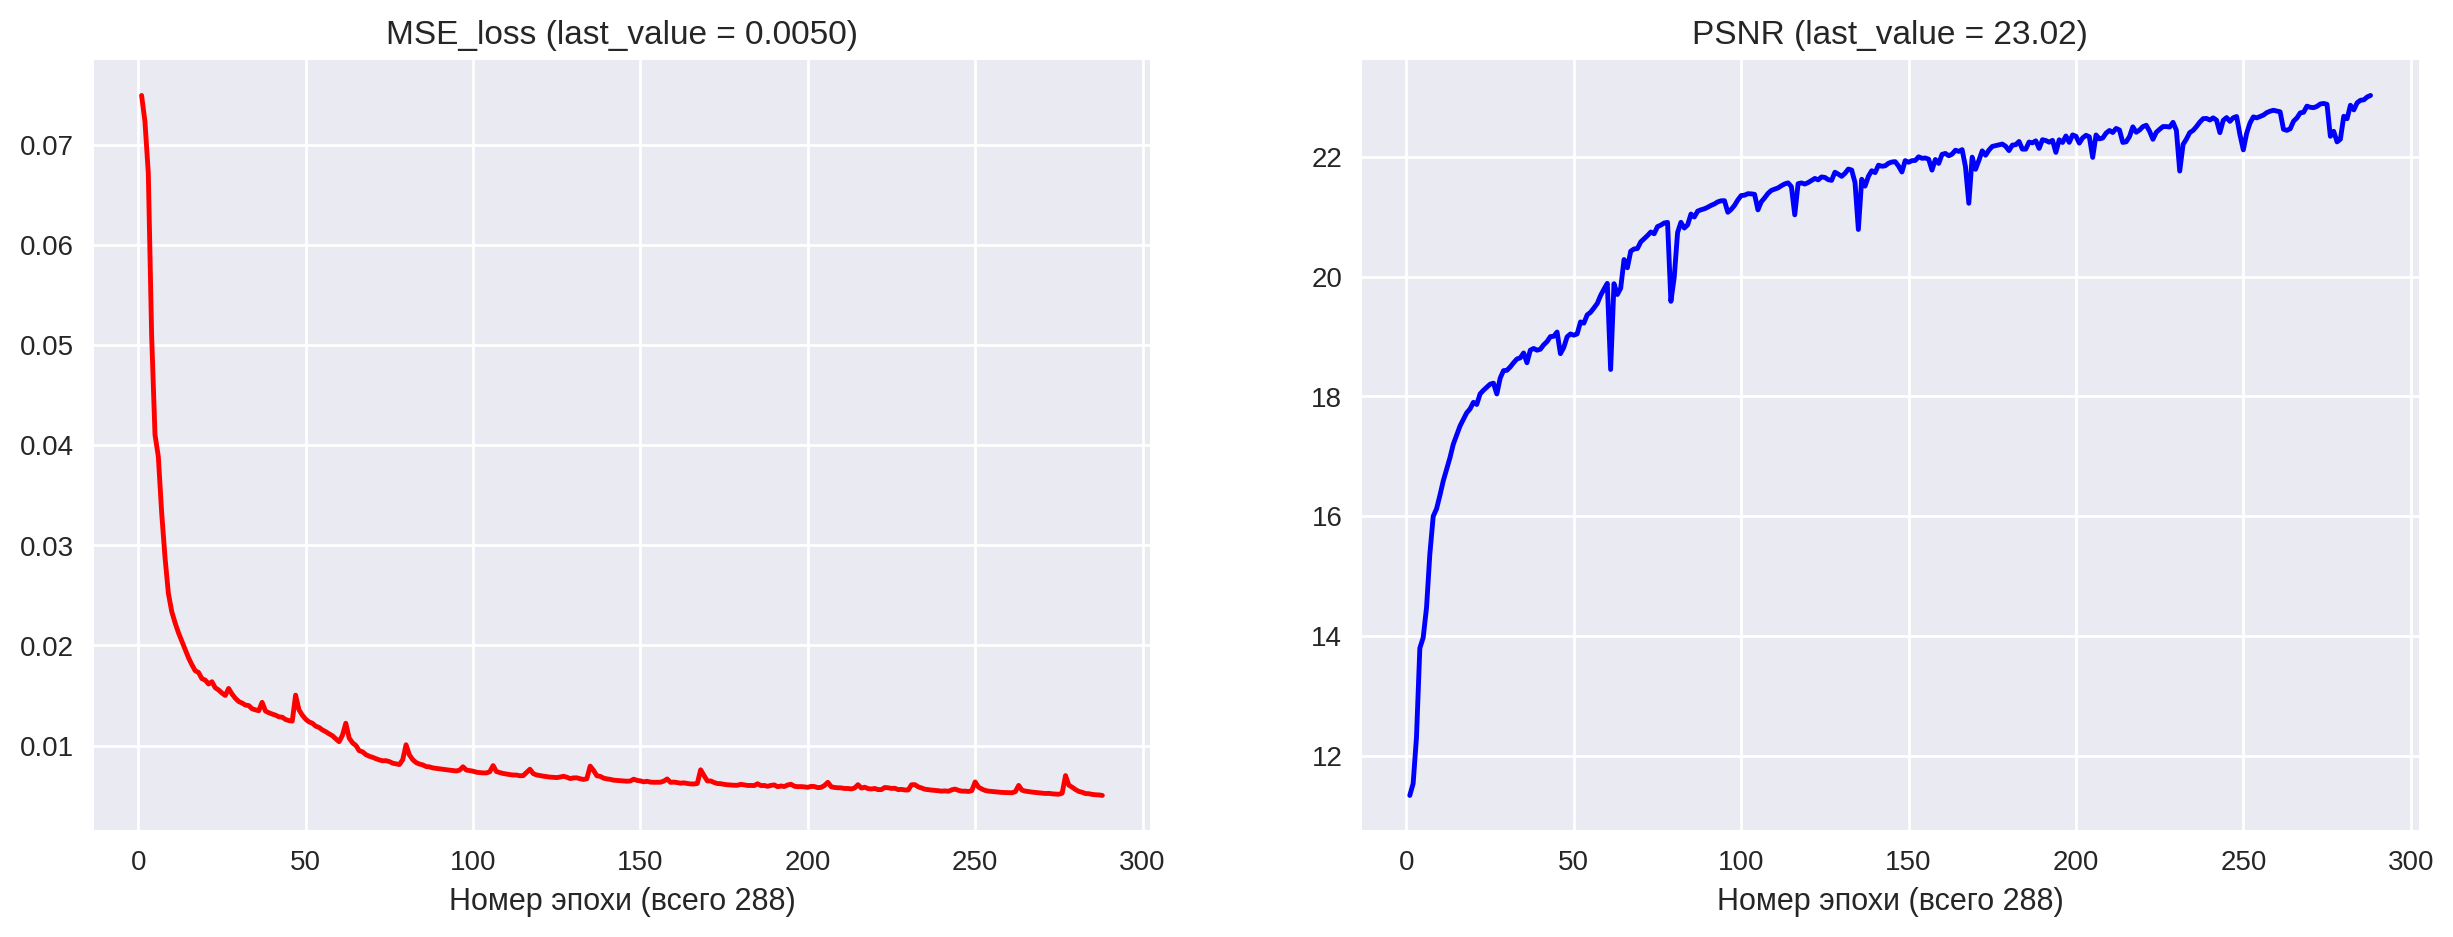

In [16]:
# визуализируем метрики
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(range(1, len(loss_list) + 1), loss_list, color="r")
plt.xlabel(f"Номер эпохи (всего {len(loss_list)})")
plt.title(f"MSE_loss (last_value = {loss_list[-1]:.{4}f})")

plt.subplot(122)
plt.plot(range(1, len(psnr_list) + 1), psnr_list, color="b")
plt.xlabel(f"Номер эпохи (всего {len(psnr_list)})")
plt.title(f"PSNR (last_value = {psnr_list[-1]:.{2}f})")

plt.show()

## Результат

Проверим на тренировочной выборке:

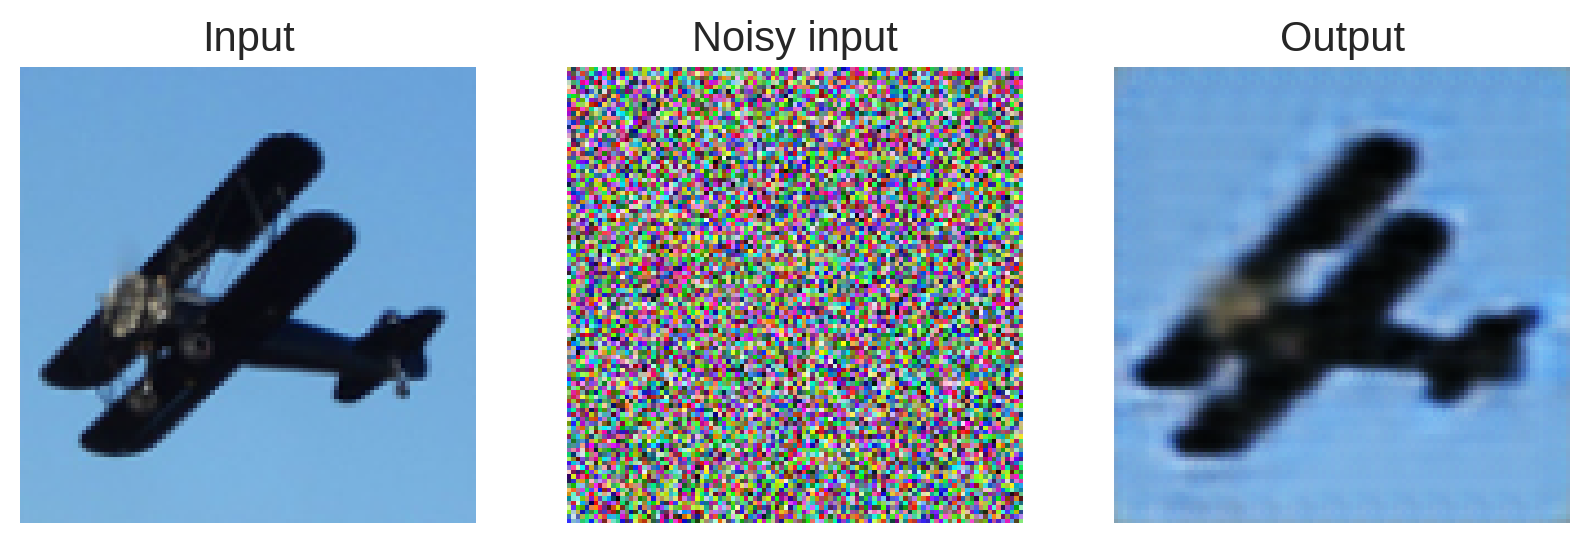

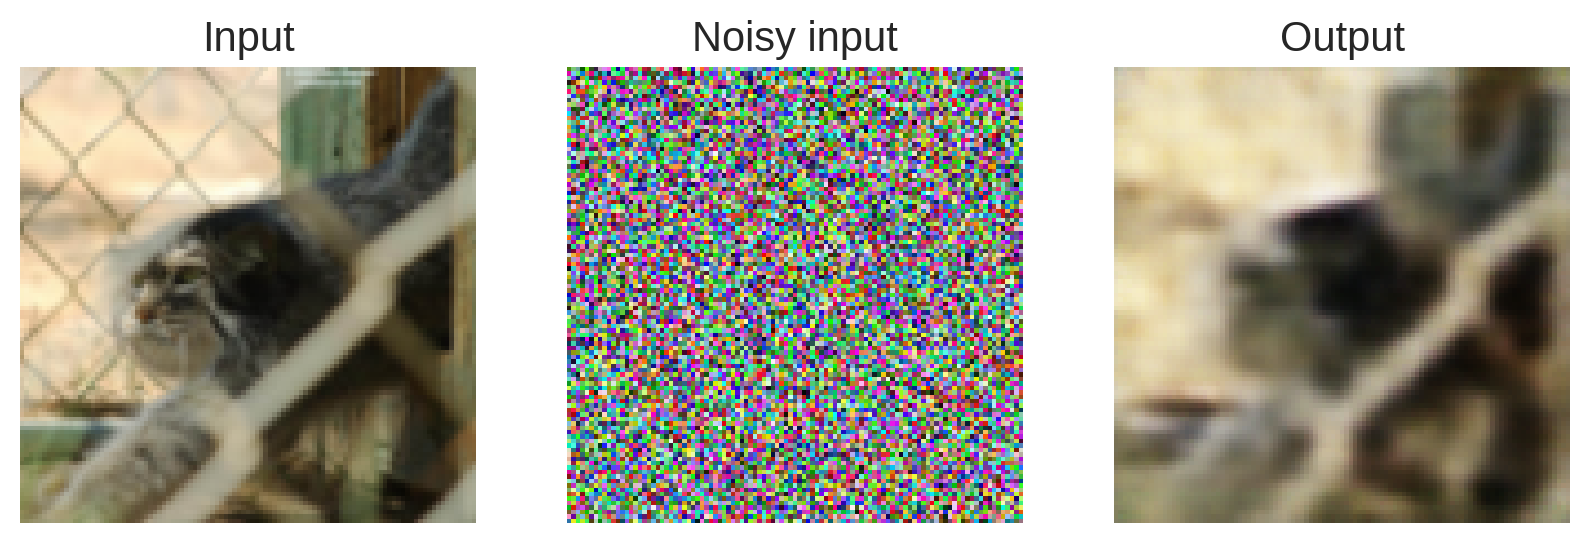

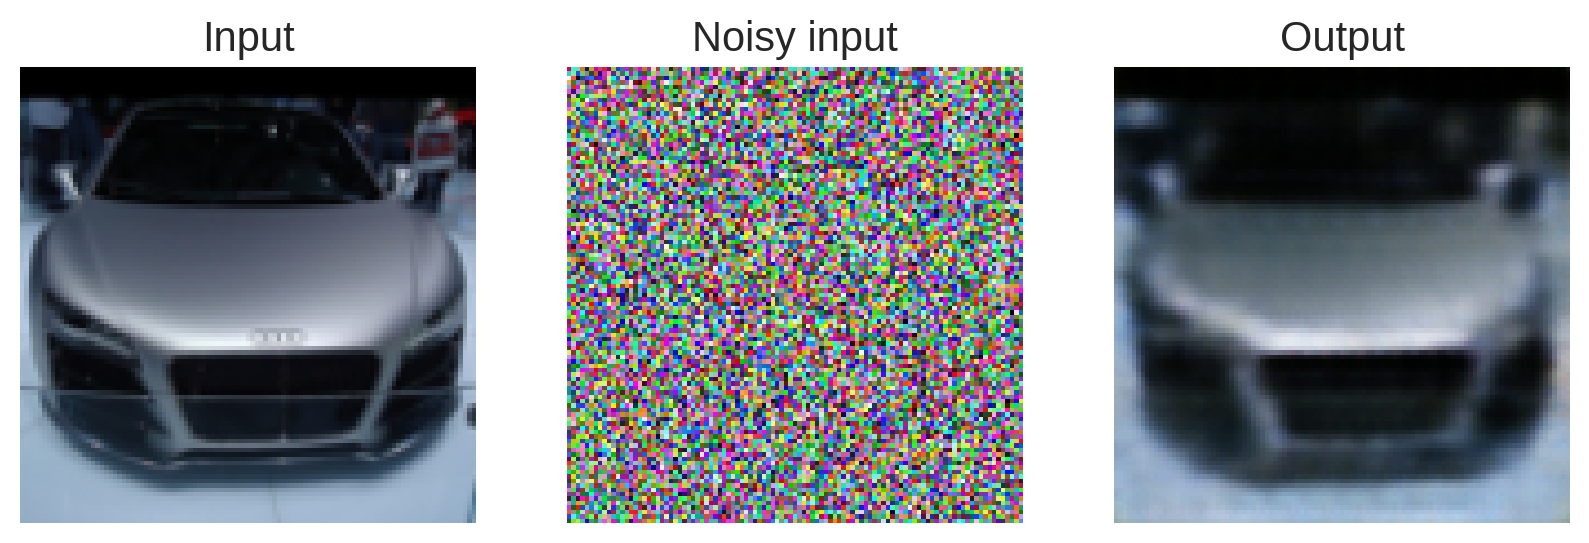

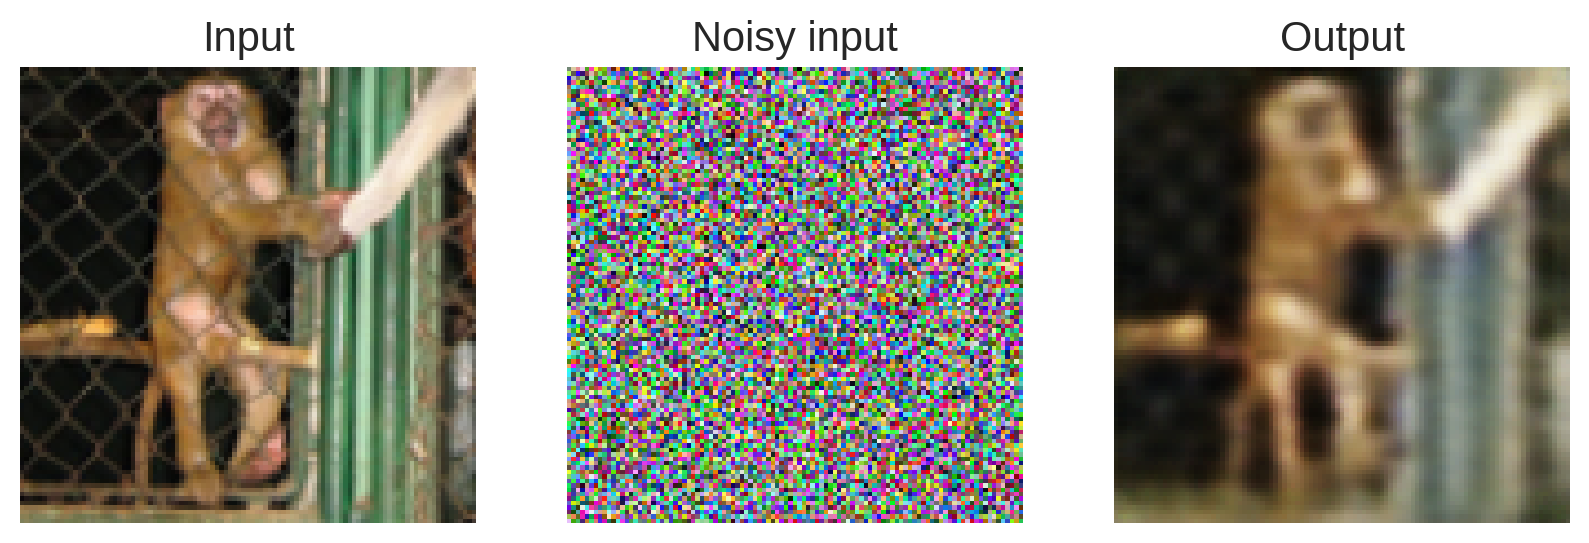

In [17]:
k = 0
with torch.no_grad():
    for data in train_dataloader:
      input, target, _, noisy_input = data
      input, target= input.to(device)/255, target.to(device)/255

      output = model(input)
      output = (output[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      input = (input[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      noisy_input = (noisy_input[0]*255).cpu().numpy().astype(np.uint8)

      plt.figure(figsize=(10,5))
      plt.subplot(131), plt.imshow(input), plt.axis('off'), plt.title('Input', size=15)
      plt.subplot(132), plt.imshow(noisy_input), plt.axis('off'), plt.title('Noisy input', size=15)
      plt.subplot(133), plt.imshow(output), plt.axis('off'), plt.title('Output', size=15)
      plt.show()

      k+=1

      if k == 10:
        break

Проверим на валидационной выборке:

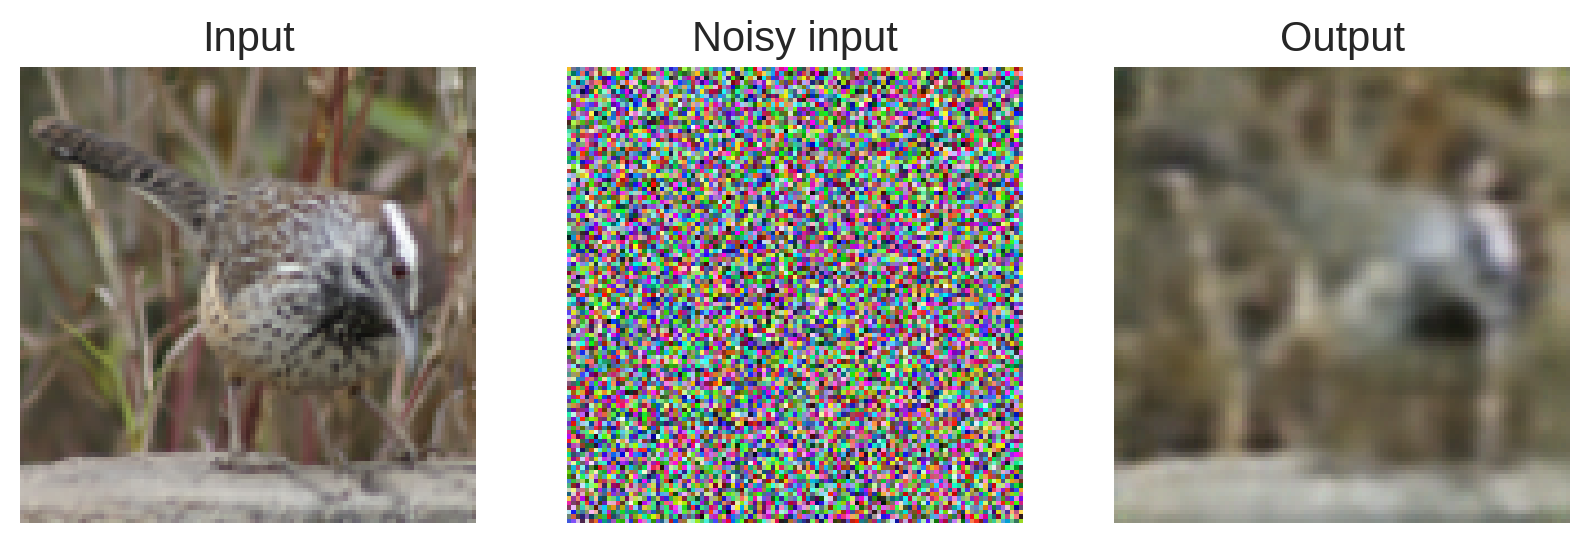

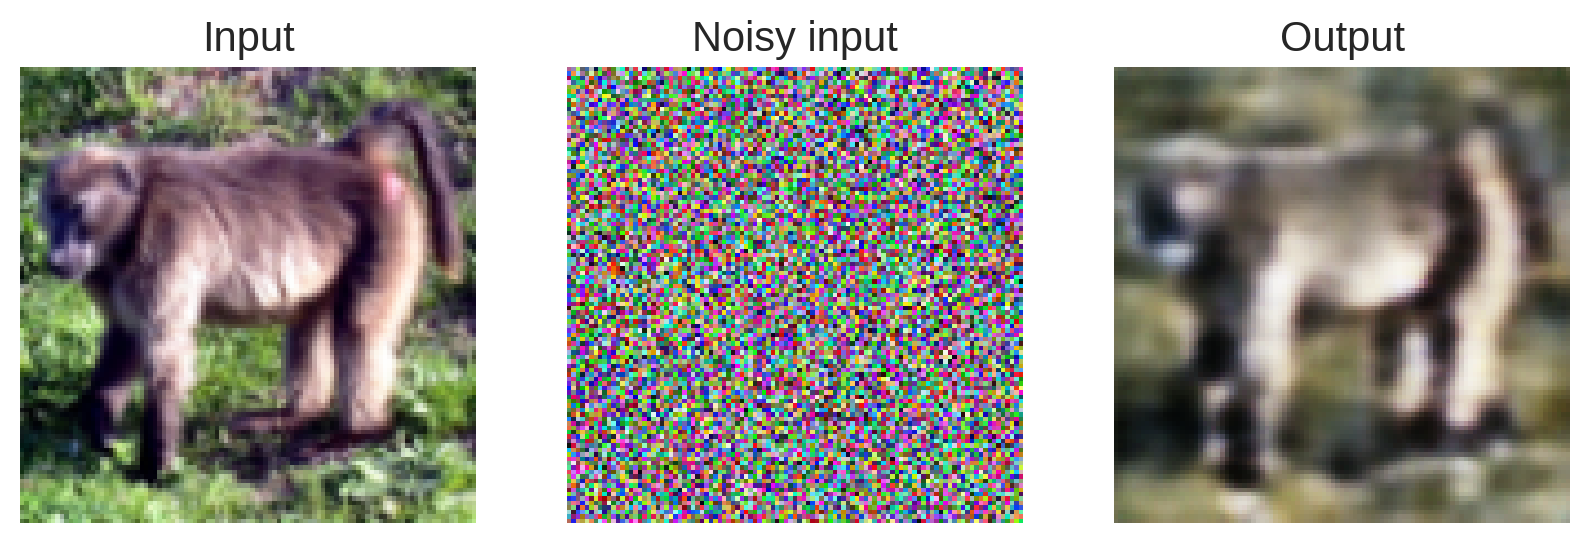

In [18]:
val_dataset = dataset['val']

val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size)

k = 0
with torch.no_grad():
    for data in val_dataloader:
      input, target, _, noisy_input = data
      input, target= input.to(device)/255, target.to(device)/255

      output = model(input)
      output = (output[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      input = (input[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      noisy_input = (noisy_input[0]*255).cpu().numpy().astype(np.uint8)

      plt.figure(figsize=(10,5))
      plt.subplot(131), plt.imshow(input), plt.axis('off'), plt.title('Input', size=15)
      plt.subplot(132), plt.imshow(noisy_input), plt.axis('off'), plt.title('Noisy input', size=15)
      plt.subplot(133), plt.imshow(output), plt.axis('off'), plt.title('Output', size=15)
      plt.show()

      k+=1

      if k == 10:
        break

# Выводы:
- условие задачи выполнено, достигнут целевой показатель PSNR = 23 на 288 эпохах
- судя по всему, модель реально еще дообучить до значений PSNR = 25-26
- автоэнкодер вполне можно использлвать для удаления шума с изображений, однако требуется время и навыки, чтобы освоить и правильно использовать данный инструмент
- для меня остался непонятным вопрос по использованию трансформаций Albumentations: при их использовании модель обучается медленней и я сомневаюсь, что целевой показатель с ними будет достигнут. Возможно, я просто неправильно использую трансформации?